In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import tensorflow as tf
system = os.name
if system == 'posix':
    KAGGLE = True
else:
    KAGGLE = False
print(os.name)

if KAGGLE:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)

nt
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
if KAGGLE:
    !pip install ../input/keras-applications/Keras_Applications-1.0.8/ -f ./ --no-index
    !pip install ../input/image-classifiers/image_classifiers-1.0.0/ -f ./ --no-index
    !pip install ../input/efficientnet-1-0-0/efficientnet-1.0.0/ -f ./ --no-index
    !pip install ../input/segmentationmodels/ -f ./ --no-index    

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import cv2
import sys
import json
import time
import pickle
import shutil
import numba
import numpy as np
import pandas as pd 
import tifffile as tiff
import rasterio
from rasterio.windows import Window
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
from tqdm.notebook import tqdm
print('tensorflow version:', tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('device available:', gpu_device)
pd.set_option('display.max_columns', None)

Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.4.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
TEST = False
if KAGGLE:
    TEST = True

VER = 38
DATA_PATH = f"../input/hubmap-kidney-segmentation"
if KAGGLE:
    MDLS_PATH = "../input/kidneymodel"
else:
    MDLS_PATH = "../models"
MDL_PATH = f"{MDLS_PATH}/models_v{VER:03}"
SUB_PATH = f"{DATA_PATH}/test" if TEST else f"{DATA_PATH}/train"
IDNT = rasterio.Affine(1, 0, 0, 0, 1, 0)
EXPAND = 4
MIN_OVERLAP = 256
STRATEGY = tf.distribute.get_strategy()
TTAS = [0, 1, 2, 3]
FOLDS = [0]
THRESHOLD = 0.4
VOTERS = 1
TARGET_IMG = 'afa5e80ztu98.tiff'
start_time = time.time()
Y_SHFT = -40
X_SHFT = -24

In [6]:
with open(f"{MDL_PATH}/params.json") as file:
    PARAMS = json.load(file)
print(f"loaded params: {PARAMS}")

loaded params: {'version': 38, 'folds': 1, 'img_size': 256, 'resize': 4, 'batch_size': 32, 'epochs': 100, 'patience': 10, 'backbone': 'efficientnetb7', 'loss': 'bce_dice', 'mirror': False, 'umodel': 'unet', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0001, 'split': 'kfold', 'seed': 69, 'mixed_precision': True, 'aughard': True, 'bavg_epoch': 52.0, 'bavg_loss': 0.017929866909980774, 'bavg_dice_coef': 0.92265784740448, 'dice_by_folds': '0.9227'}


In [7]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

def global_shift_mask(maskpred1, y_shift, x_shift):
    """
    applies a global shift to a mask by padding
    one side and cropping from the other
    """
    if y_shift < 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(0,abs(y_shift)), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, :maskpred1.shape[1]]
    elif y_shift >= 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], abs(x_shift):]
    elif y_shift >= 0 and x_shift >= 0:
        maskpred2 = np.pad(maskpred1, [(abs(y_shift),0), (abs(x_shift), 0)], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[:maskpred1.shape[0], :maskpred1.shape[1]]
    elif y_shift < 0 and x_shift < 0:
        maskpred2 = np.pad(maskpred1, [(0, abs(y_shift)), (0, abs(x_shift))], mode = "constant", constant_values=0)
        maskpred3 = maskpred2[abs(y_shift):, abs(x_shift):]
    return maskpred3

In [8]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred, smooth))

def bce_dice_loss(y_true, y_pred):
    return params["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - params["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice",
              umodel = "unet", classes = 1, lr = 0.001):
    if backbone == "efficientnetb0":
        weights = f"{MDLS_PATH}/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
    elif backbone == "efficientnetb2":
        weights = f"{MDLS_PATH}/efficientnet-b2_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
    elif backbone == "efficientnetb7":
        weights = f"{MDLS_PATH}/efficientnet-b7_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
    else:
        raise AttributeError("backbone unknown")
    if not KAGGLE:
        weights = "imagenet"
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
        else:
            raise AttributeError("loss mode parameter error")
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = weights,
                         input_shape = input_shape,
                         classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = weights,
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
        else:
            raise AttributeError("umodel mode parameter error")
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr)
            ),
            loss = loss,
            metrics = [dice_coef]
        )
    return model

In [9]:
def make_grid(shape, window = 256, min_overlap = 32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num = nx, endpoint = False, dtype = np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num = ny, endpoint = False, dtype = np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx, ny, 4), dtype = np.int64)
    for i in range(nx):
        for j in range(ny):
            slices[i, j] = x1[i], x2[i], y1[j], y2[j]
    return slices.reshape(nx * ny, 4)

def flip(img, axis = 0):
    if axis == 1:
        return img[::-1, :, ]
    elif axis == 2:
        return img[:, ::-1, ]
    elif axis == 3:
        return img[::-1, ::-1, ]
    else:
        return img

In [10]:
img_files = [x for x in os.listdir(SUB_PATH) if ".tiff" in x]
print(f"images idxs: {img_files}")

images idxs: ['0486052bb.tiff', '095bf7a1f.tiff', '1e2425f28.tiff', '26dc41664.tiff', '2f6ecfcdf.tiff', '4ef6695ce.tiff', '54f2eec69.tiff', '8242609fa.tiff', 'aaa6a05cc.tiff', 'afa5e8098.tiff', 'b2dc8411c.tiff', 'b9a3865fc.tiff', 'c68fe75ea.tiff', 'cb2d976f4.tiff', 'e79de561c.tiff']


In [11]:
subm = {}
for i_img, img_file in enumerate(img_files):
    print("-" * 20, img_file, "-" * 20)
    img_data = rasterio.open(os.path.join(SUB_PATH, img_file), transform=IDNT)
    print("img shape: ", img_data.shape)
    if img_data.count != 3:
        print("img file with subdatasets as channels")
        layers = [rasterio.open(subd) for subd in img_data.subdatasets]
    img_preds = np.zeros(img_data.shape, dtype=np.uint8)
    tile_size = int(PARAMS["img_size"] * EXPAND)
    tile_resized = int(tile_size * PARAMS["resize"])
    slices = make_grid(
        img_data.shape,
        window = tile_resized,
        min_overlap = MIN_OVERLAP
    )
    models = []
    folds = FOLDS
    for n_fold in folds:
        checkpoint_path = f"{MDL_PATH}/model_{n_fold}.hdf5"
        model = get_model(
            PARAMS["backbone"],
            input_shape = (tile_size, tile_size, 3),
            loss_type = PARAMS["loss"],
            umodel = PARAMS["umodel"]
        )
        model.load_weights(checkpoint_path)
        models.append(model)
        print("model loaded:", checkpoint_path)
    for (x1, x2, y1, y2) in tqdm(slices, desc = f"{img_file}"):
        if img_data.count == 3: #normal
            img = img_data.read(
                [1, 2, 3],
                window = Window.from_slices((x1, x2), (y1, y2))
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((tile_resized, tile_resized, 3), dtype = np.uint8)
            for fl in range(3):
                img[:, :, fl] = layers[fl].read(
                    window = Window.from_slices((x1, x2), (y1, y2))
                )
        img = cv2.resize(img, (tile_size, tile_size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        pred = np.zeros((tile_size, tile_size), dtype = np.float32)
        for tta_mode in TTAS:
            img_aug = flip(img, axis = tta_mode)
            img_aug = np.expand_dims(img_aug, 0)
            img_aug = img_aug.astype(np.float32) / 255
            pred_aug = np.zeros((tile_size, tile_size), dtype = np.float32)
            for model in models:
                pred_aug += np.squeeze(model.predict(img_aug)) / len(models)
            pred += flip(pred_aug, axis = tta_mode) / len(TTAS)
        pred = cv2.resize(pred, (tile_resized, tile_resized))
        img_preds[x1:x2, y1:y2] = img_preds[x1:x2, y1:y2] + \
            (pred > THRESHOLD).astype(np.uint8)
    del model, models, img, pred, img_aug, pred_aug; gc.collect()
    print("img max", np.max(img_preds), "| voters:", VOTERS)
    if img_file == TARGET_IMG:
        print("global shift")
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
        img_preds = global_shift_mask(img_preds, Y_SHFT, X_SHFT)
    else:
        img_preds = (img_preds >= VOTERS).astype(np.uint8)
    rle_pred = rle_encode_less_memory(img_preds)
    subm[i_img] = {"id": img_file.replace(".tiff", ""), "predicted": rle_pred}
    del img_preds, img_data, rle_pred; gc.collect()

elapsed_time = time.time() - start_time
print(f"time elapsed: {elapsed_time // 60:.0f} min {elapsed_time % 60:.0f} sec")

-------------------- 0486052bb.tiff --------------------
img shape:  (25784, 34937)
model loaded: ../models/models_v038/model_0.hdf5


0486052bb.tiff:   0%|          | 0/70 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 095bf7a1f.tiff --------------------
img shape:  (38160, 39000)
img file with subdatasets as channels
model loaded: ../models/models_v038/model_0.hdf5


095bf7a1f.tiff:   0%|          | 0/110 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 1e2425f28.tiff --------------------
img shape:  (26780, 32220)
img file with subdatasets as channels
model loaded: ../models/models_v038/model_0.hdf5


1e2425f28.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 26dc41664.tiff --------------------
img shape:  (38160, 42360)
img file with subdatasets as channels
model loaded: ../models/models_v038/model_0.hdf5


26dc41664.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 2f6ecfcdf.tiff --------------------
img shape:  (31278, 25794)
model loaded: ../models/models_v038/model_0.hdf5


2f6ecfcdf.tiff:   0%|          | 0/63 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 4ef6695ce.tiff --------------------
img shape:  (39960, 50680)
img file with subdatasets as channels
model loaded: ../models/models_v038/model_0.hdf5


4ef6695ce.tiff:   0%|          | 0/154 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 54f2eec69.tiff --------------------
img shape:  (30440, 22240)
model loaded: ../models/models_v038/model_0.hdf5


54f2eec69.tiff:   0%|          | 0/48 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- 8242609fa.tiff --------------------
img shape:  (31299, 44066)
model loaded: ../models/models_v038/model_0.hdf5


8242609fa.tiff:   0%|          | 0/108 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- aaa6a05cc.tiff --------------------
img shape:  (18484, 13013)
model loaded: ../models/models_v038/model_0.hdf5


aaa6a05cc.tiff:   0%|          | 0/20 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- afa5e8098.tiff --------------------
img shape:  (36800, 43780)
model loaded: ../models/models_v038/model_0.hdf5


afa5e8098.tiff:   0%|          | 0/120 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- b2dc8411c.tiff --------------------
img shape:  (14844, 31262)
model loaded: ../models/models_v038/model_0.hdf5


b2dc8411c.tiff:   0%|          | 0/36 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- b9a3865fc.tiff --------------------
img shape:  (31295, 40429)
model loaded: ../models/models_v038/model_0.hdf5


b9a3865fc.tiff:   0%|          | 0/99 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- c68fe75ea.tiff --------------------
img shape:  (26840, 49780)
img file with subdatasets as channels
model loaded: ../models/models_v038/model_0.hdf5


c68fe75ea.tiff:   0%|          | 0/91 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- cb2d976f4.tiff --------------------
img shape:  (34940, 49548)
model loaded: ../models/models_v038/model_0.hdf5


cb2d976f4.tiff:   0%|          | 0/130 [00:00<?, ?it/s]

img max 4 | voters: 1
-------------------- e79de561c.tiff --------------------
img shape:  (16180, 27020)
model loaded: ../models/models_v038/model_0.hdf5


e79de561c.tiff:   0%|          | 0/40 [00:00<?, ?it/s]

img max 4 | voters: 1
time elapsed: 23 min 29 sec


In [12]:
df_sub = pd.DataFrame(subm).T
df_sub

,id,predicted
0,0486052bb,101753437 29 101779213 52 101804992 70 1018307...
1,095bf7a1f,118162736 19 118200880 43 118239033 56 1182771...
2,1e2425f28,49453112 10 49479882 33 49506657 45 49533434 5...
3,26dc41664,246289655 6 246327810 16 246329046 27 24636596...
4,2f6ecfcdf,296115851 31 296147122 44 296178393 56 2962096...
5,4ef6695ce,137121896 25 137161848 38 137201803 47 1372417...
6,54f2eec69,124632199 36 124662605 77 124693035 91 1247234...
7,8242609fa,97066495 24 97097788 34 97129080 47 97160373 6...
8,aaa6a05cc,31026101 12 31044575 34 31063054 47 31081536 5...
9,afa5e8098,66169247 18 66206042 26 66242830 41 66279619 5...


In [13]:
df_sub.to_csv("submission.csv", index = False)

(25784, 34937, 3)
(25784, 34937, 3)
(25784, 34937)
(25784, 34937)


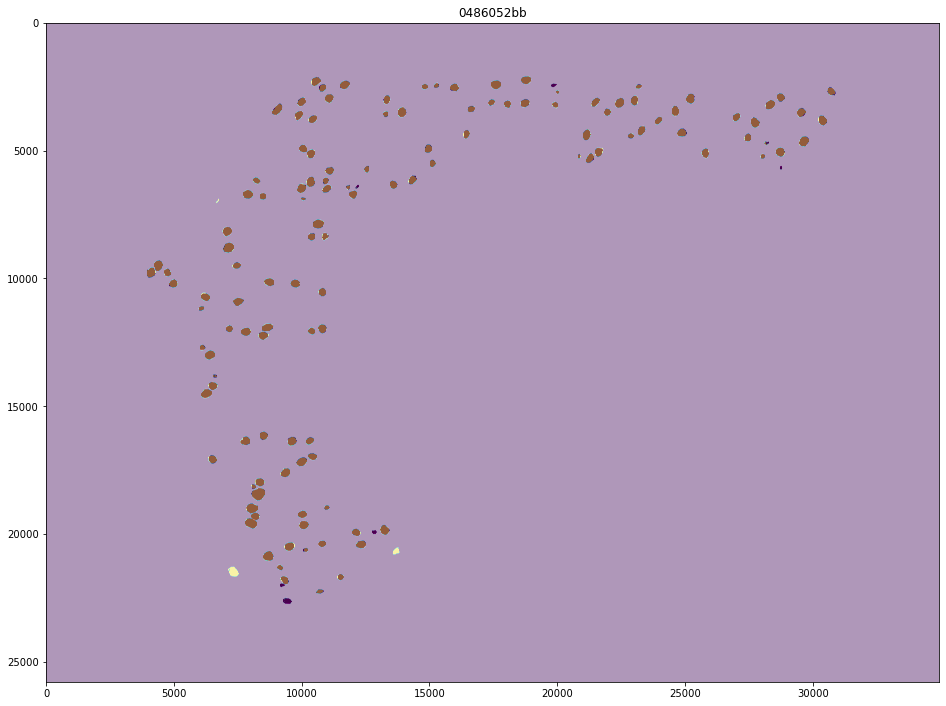

time elapsed: 30 min, 23 sec
(3, 38160, 39000)
(38160, 39000, 3)
(38160, 39000)
(38160, 39000)


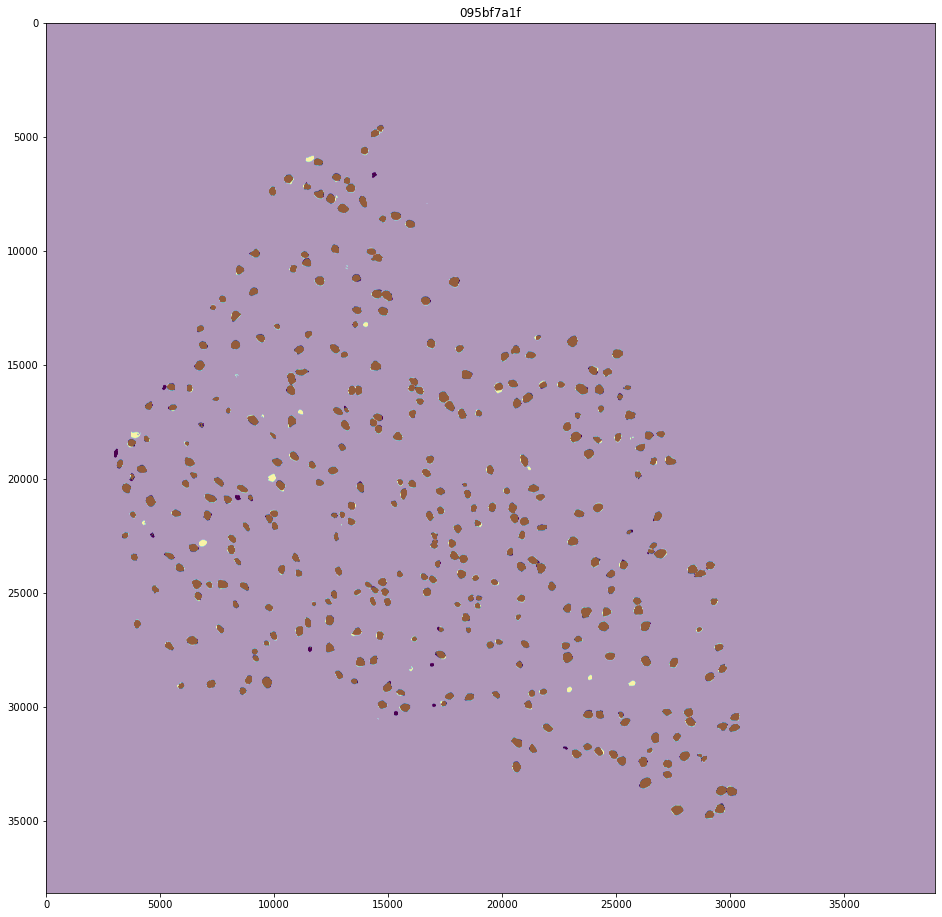

time elapsed: 34 min, 45 sec
(3, 26780, 32220)
(26780, 32220, 3)
(26780, 32220)
(26780, 32220)


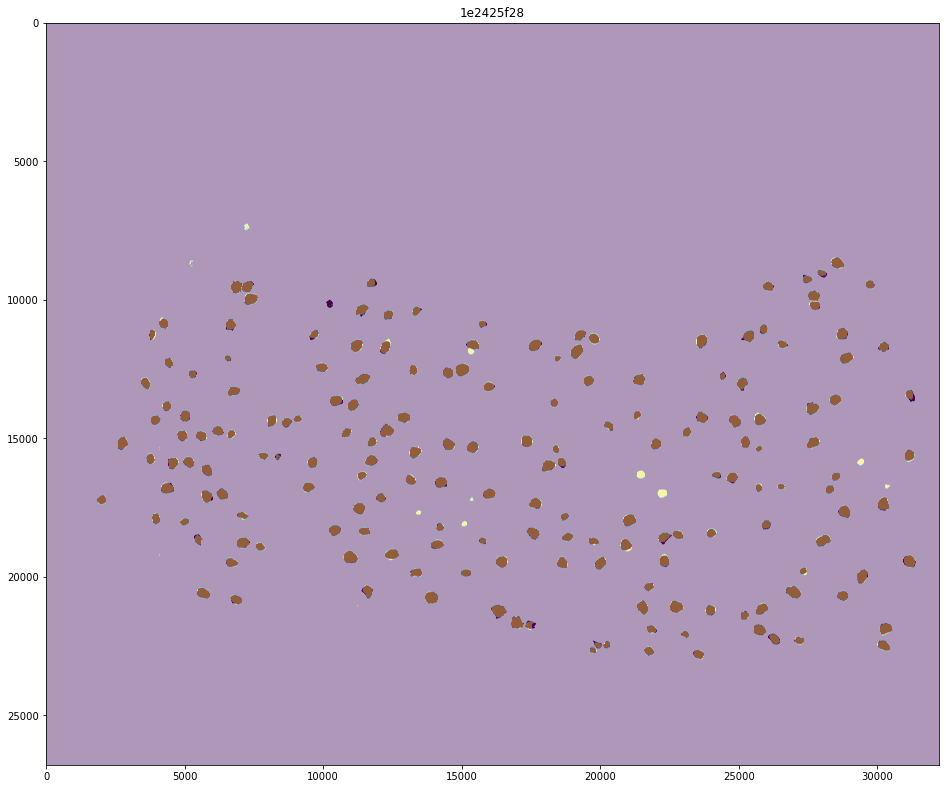

time elapsed: 37 min, 31 sec
(3, 38160, 42360)
(38160, 42360, 3)
(38160, 42360)
(38160, 42360)


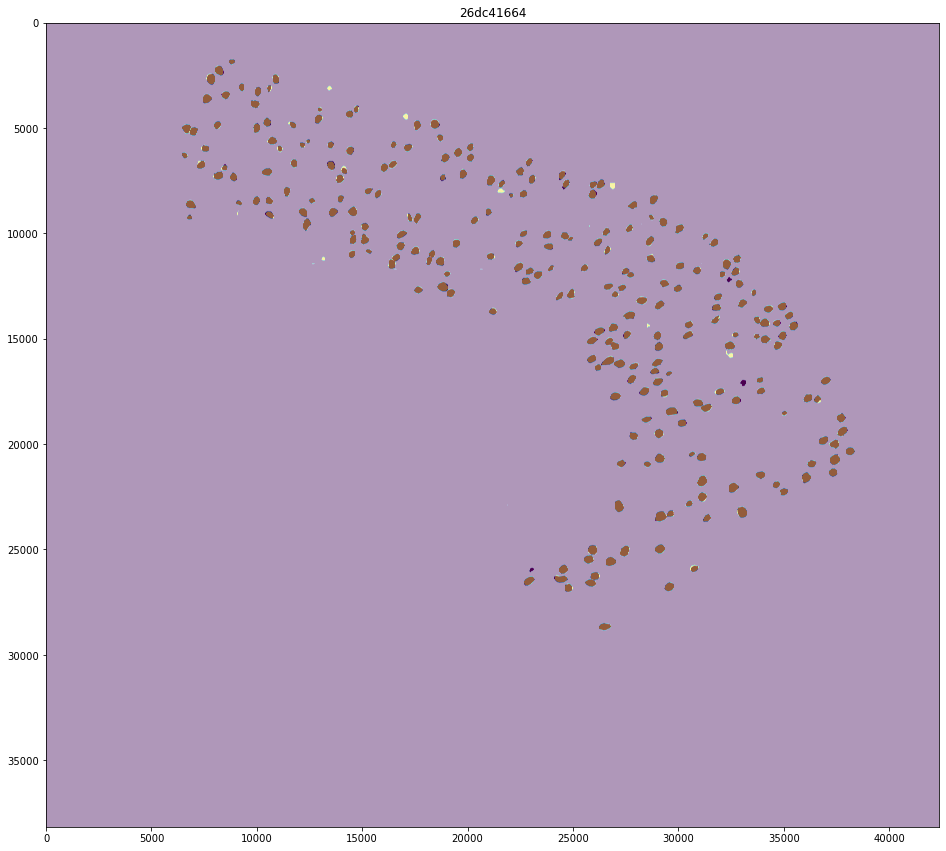

time elapsed: 42 min, 6 sec
(31278, 25794, 3)
(31278, 25794, 3)
(31278, 25794)
(31278, 25794)


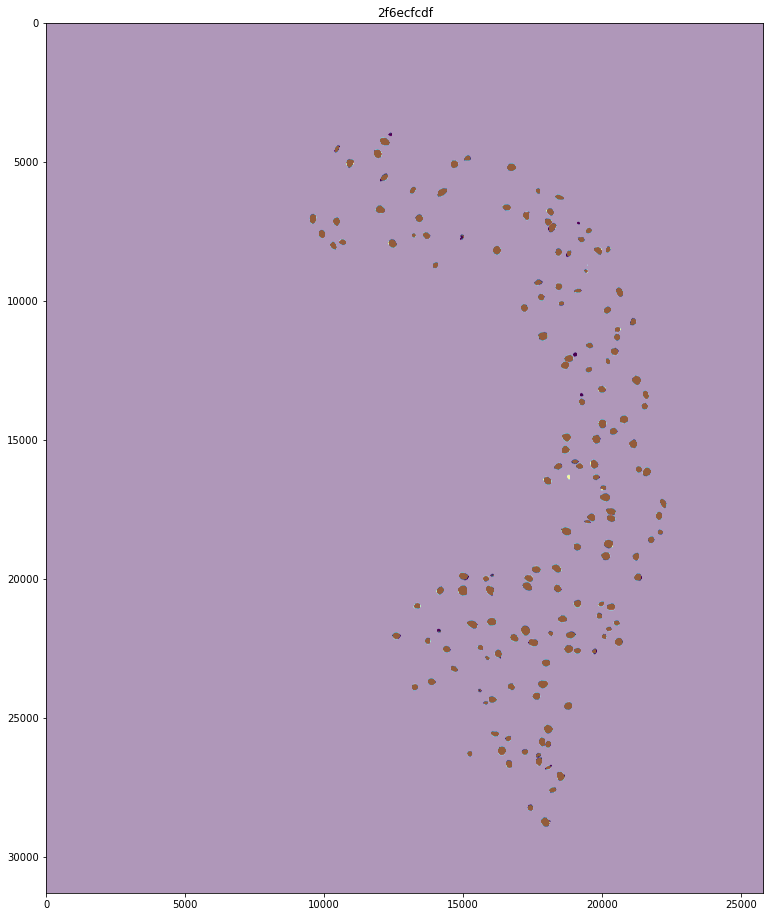

time elapsed: 44 min, 35 sec
(3, 39960, 50680)
(39960, 50680, 3)
(39960, 50680)
(39960, 50680)


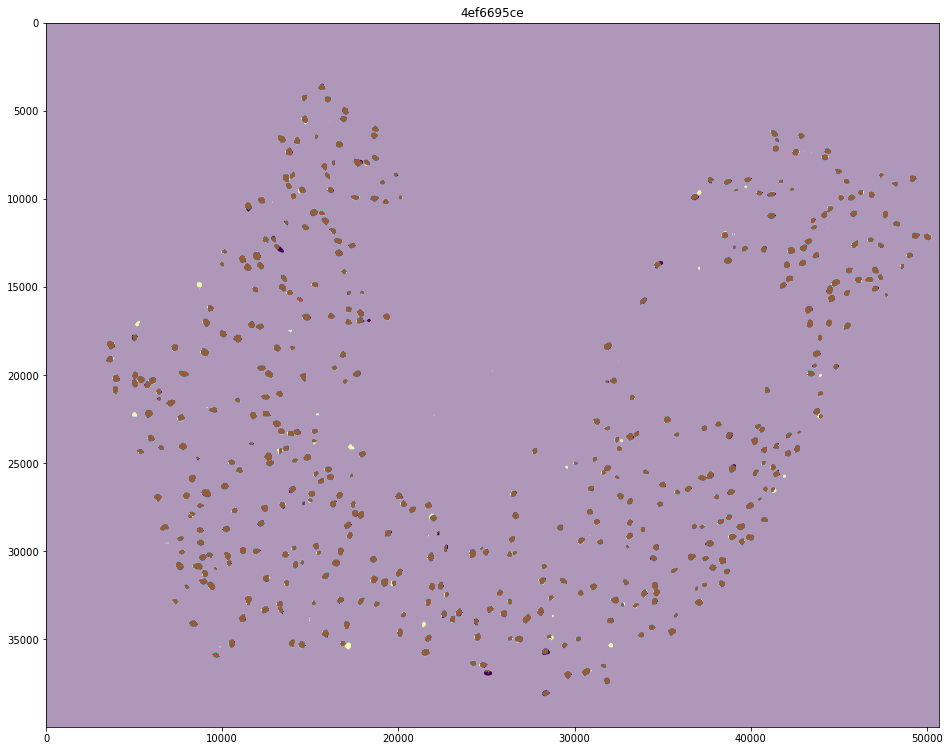

time elapsed: 49 min, 52 sec
(1, 1, 3, 30440, 22240)
(1, 1, 3, 30440, 22240)
(1, 1)
(1, 1)


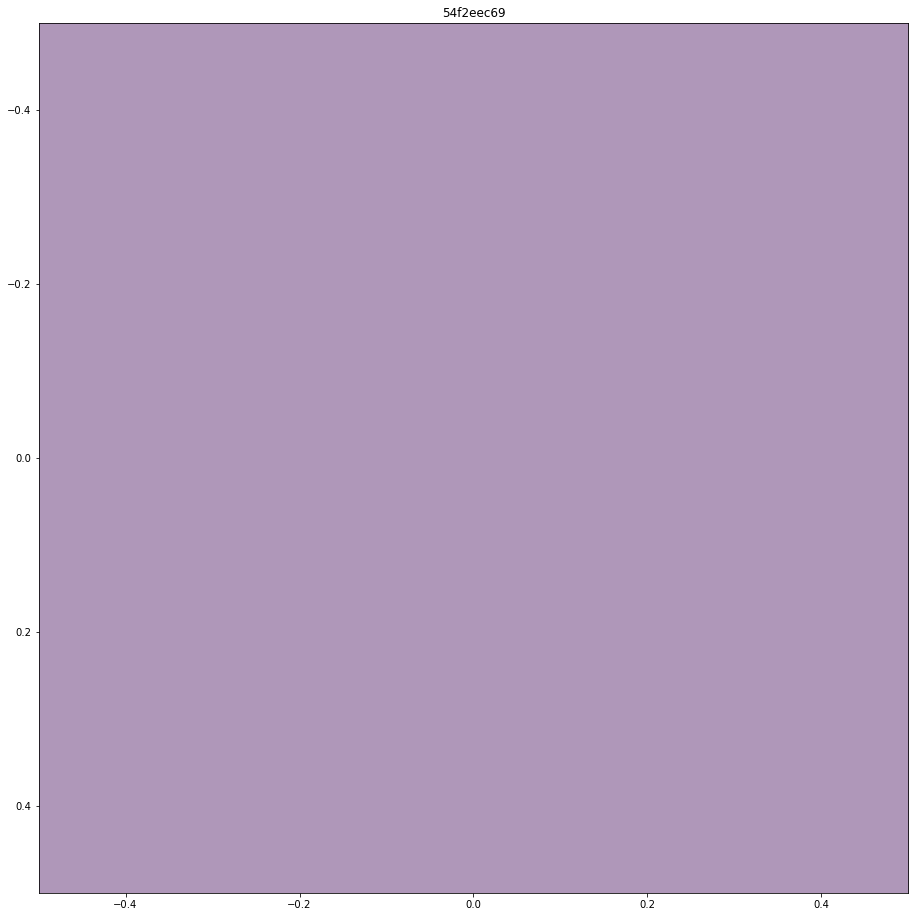

time elapsed: 50 min, 0 sec
(31299, 44066, 3)
(31299, 44066, 3)
(31299, 44066)
(31299, 44066)


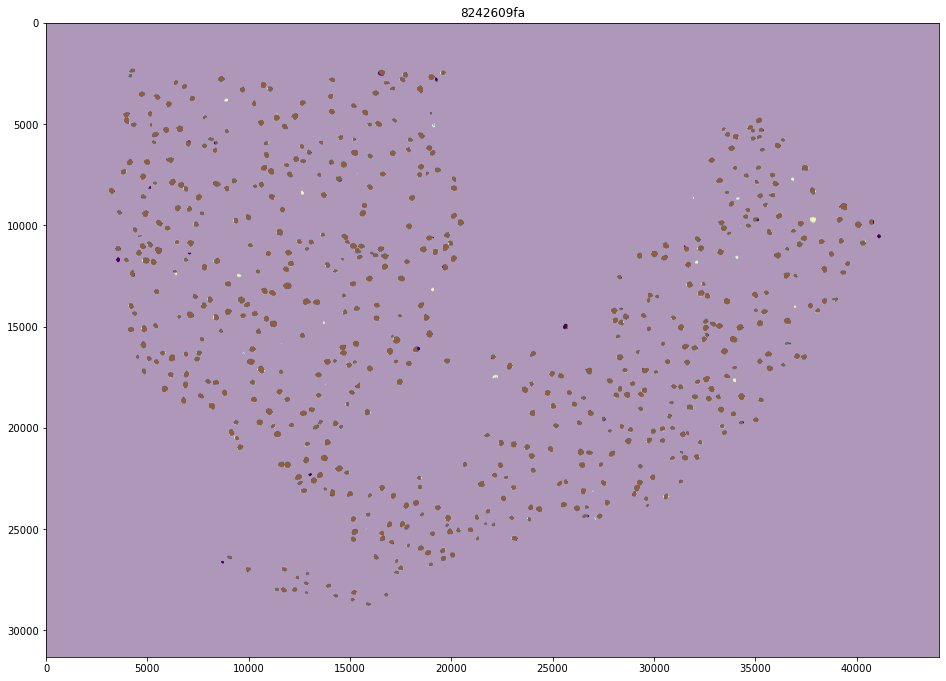

time elapsed: 53 min, 31 sec
(18484, 13013, 3)
(18484, 13013, 3)
(18484, 13013)
(18484, 13013)


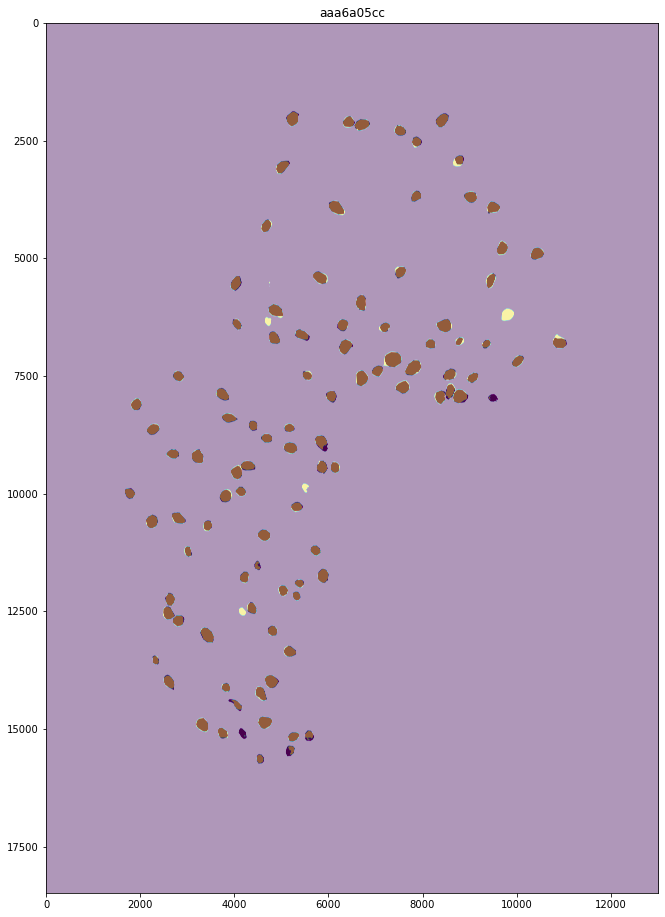

time elapsed: 54 min, 17 sec
(36800, 43780, 3)
(36800, 43780, 3)
(36800, 43780)
(36800, 43780)


In [ ]:
i = 1
if not KAGGLE:
    for i in df_sub.index:
        if not TEST:
            df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
            idx = df_sub.iloc[i].id
            img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
            print(img.shape)
            if img.shape[0] == 3: img = np.transpose(img.squeeze(), (1, 2, 0))
            msk_p = enc2mask([df_sub.iloc[i].predicted], (img.shape[1], img.shape[0]))
            msk = enc2mask([df_masks.loc[idx, "encoding"]], (img.shape[1], img.shape[0]))
            print(img.shape)
            print(msk_p.shape)
            print(msk.shape)

            #plt.figure(figsize = (16, 16))
            #plt.imshow(img)
            #plt.imshow(msk, alpha = 0.3)
            #plt.title(idx)
            #plt.show()

            #plt.figure(figsize = (16, 16))
            #plt.figure(figsize = (16, 16))
            #plt.imshow(img)
            #plt.imshow(msk_p, alpha = 0.3)
            #plt.title(idx)
            #plt.show()

            plt.figure(figsize = (16, 16))
            plt.imshow(msk, alpha = 1, cmap = "BuPu")
            plt.imshow(msk_p, alpha = 0.4)
            plt.title(idx)
            plt.savefig(f'{MDL_PATH}/{idx}-thr-{int(THRESHOLD * 10)}-tta-{len(TTAS)}-{int(time.time())}.jpeg', transparent=True, bbox_inches = 'tight',
                                facecolor = 'k',pad_inches = 0)
            plt.show()
        else:
            idx = df_sub.iloc[0].id
            img = tiff.imread(os.path.join(SUB_PATH, idx + ".tiff"))
            if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
            msk_p = enc2mask([df_sub.iloc[0].predicted], (img.shape[1], img.shape[0]))
            print(img.shape)
            print(msk_p.shape)
            plt.figure(figsize = (16, 16))
            plt.imshow(img)
            plt.imshow(msk_p, alpha = 0.4)
            plt.title(idx)
            plt.show()
        elapsed_time = time.time() - start_time
        print(f"time elapsed: {elapsed_time // 60:.0f} min, {elapsed_time % 60:.0f} sec")